##Importing pytorch and setting up device-agnostic code


In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cpu'

In [2]:
 #setting device agnostic code
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

device

'cpu'

##Getting data

our dataset is a subset of Food101 dataset

Food101 have 101 classes and 1000 images per classes

our dataset have 3 classes and 100 images per classes(75-training and 25-testing)-approximate



In [3]:
import requests
import zipfile
from pathlib import Path

# creating image folder path
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"creating {image_path} directory")
  image_path.mkdir(parents=True,exist_ok=True)

# dowloading data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("dowloading data...")
  f.write(request.content)

#unzipping file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("unzipping data...")
  zip_ref.extractall(image_path)


creating data\pizza_steak_sushi directory
dowloading data...
unzipping data...


##Data prepration and exploration

In [4]:
import os

def walk_through_dir(dir_path):
  """Walks through directory path returning its contents"""
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [5]:
#setting train and test paths
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [6]:
###visualizing the image
import random
from PIL import Image

# random.seed(42)

image_path_list=list(image_path.glob("*/*/*.jpg"))

random_image_path=random.choice(image_path_list)

print(random_image_path)

image_class=random_image_path.parent.stem
print(image_class)

img=Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

data\pizza_steak_sushi\test\steak\1302563.jpg
steak
Random image path: data\pizza_steak_sushi\test\steak\1302563.jpg
Image class: steak
Image height: 512
Image width: 512


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

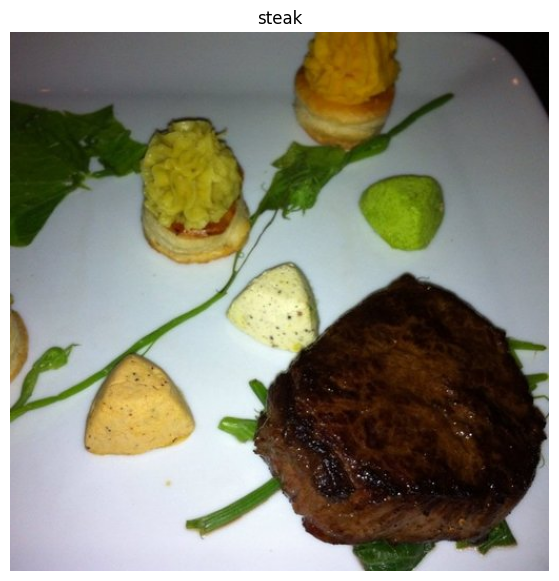

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.imshow(img)
plt.title(image_class)
plt.axis(False)

In [8]:
import numpy as np
image_as_array=np.asarray(img)
image_as_array.shape
# print(image_as_array)

(512, 512, 3)

##Transforming data

we need to transform our data into tensor

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

###transforming data with `torchvision.transforms`

In [10]:
data_transform=transforms.Compose([
    transforms.Resize((64,64)),#it will resize the image to 64X64
    transforms.RandomHorizontalFlip(p=0.5),#flips randomly an image to horizontal
    transforms.ToTensor()#converts the img to tensor
])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

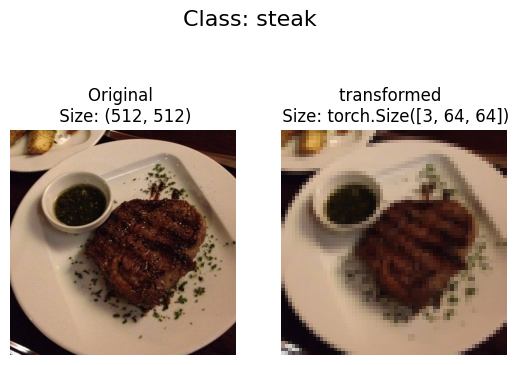

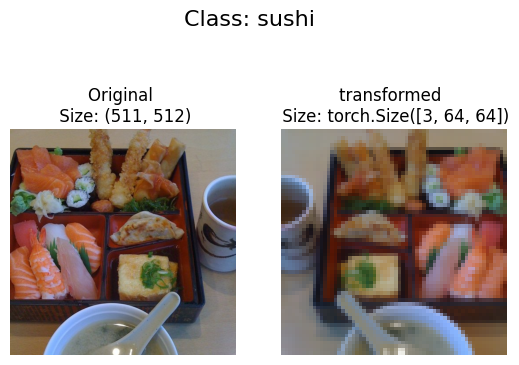

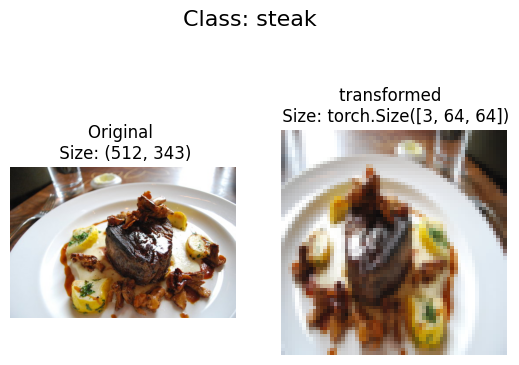

In [12]:
def plot_transformed_images(image_paths,transform,n=3,seed=None):
  """the function plots n transformed images"""
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax=plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis("off")

      transformed_image=transform(f)
      ax[1].imshow(transformed_image.permute(1,2,0))#at 0<-1 1<-2 2<-0
      ax[1].set_title(f"transformed \n Size: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_path_list,data_transform)

##ImageFolder->loading image using '`ImageFolder`

we will load image classification data using torchvision.datasets.ImageFolder

In [13]:
#creating datset using ImageFolder
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform,
                                )

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
len(train_data),len(test_data)

(225, 75)

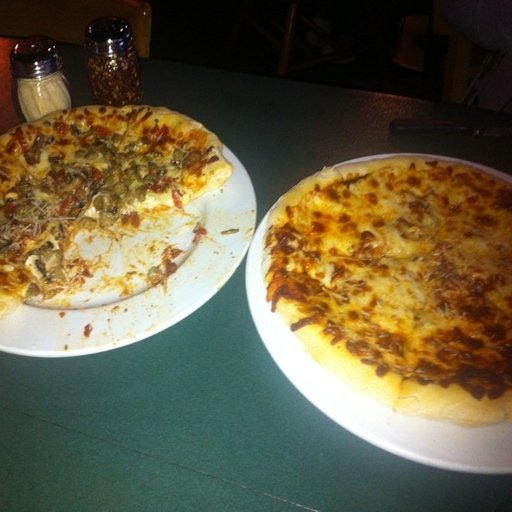

In [16]:
Image.open(train_data.samples[0][0])

In [17]:
img,label=train_data[0]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label} = {class_names[label]}")
print(f"label datatype: {type(label)}")



Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0 = pizza
label datatype: <class 'int'>


In [18]:
img.shape

torch.Size([3, 64, 64])

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

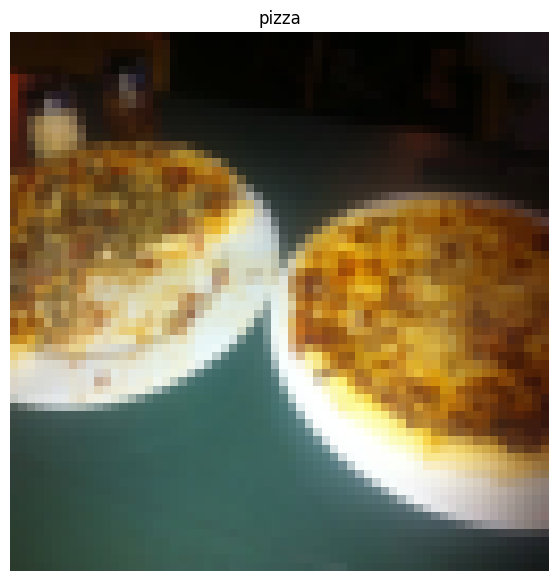

In [19]:
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])

plt.axis(False)

###turning loaded data into `DataLoader`

In [20]:
from torch.utils.data import DataLoader

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=1,
                            num_workers=os.cpu_count(),
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                           batch_size=1,
                           num_workers=os.cpu_count(),
                           shuffle=False)

In [21]:
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x162ccf34b50>,
 <torch.utils.data.dataloader.DataLoader at 0x162cce9eb90>)

In [22]:
img,label=next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label} = {class_names[label]}")

Image shape: torch.Size([1, 3, 64, 64])
Image datatype: torch.float32
Image label: tensor([1]) = steak


##Data Augmentation

it is a technique of artificially increasing the training data by creating modified copies of a dataset using existing data

In [23]:
# transforms -https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

train_transform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31,),
    transforms.ToTensor()
])

test_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

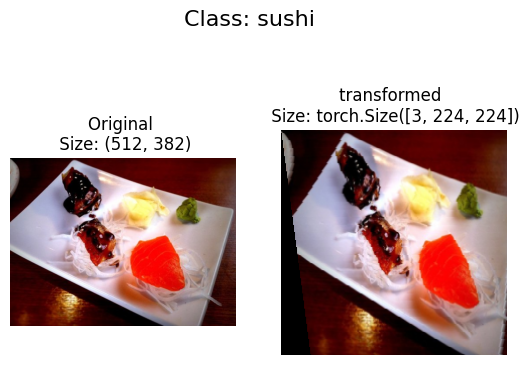

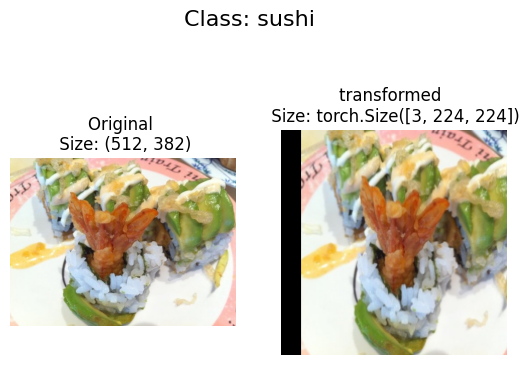

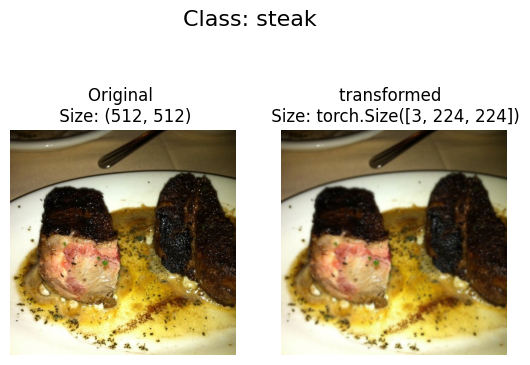

In [24]:
plot_transformed_images(image_path_list,train_transform,n=3)

##Model 0 (TinyVGG)

without data augmentation

###creating transforms and loading data for model 0

In [25]:
simple_transform= transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [26]:
from torchvision import datasets

train_data_simple=datasets.ImageFolder(root=train_dir,
                                       transform=simple_transform)
test_data_simple=datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

In [27]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE=32

train_dataloader_simple=DataLoader(dataset=train_data_simple,
                                batch_size=BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle=True)
test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                  batch_size=BATCH_SIZE,
                                  num_workers=os.cpu_count(),
                                  shuffle=False)



###Creating model class

In [28]:
class TinyVGG(nn.Module):
  """creates the TinyVGG architecture from CNN Explainer"""
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()

    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )

    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self,x):
    x=self.conv_block_1(x)
    # print(x.shape)
    x=self.conv_block_2(x)
    # print(x.shape)
    x=self.classifier(x)
    # print(x.shape)
    return x


In [29]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

###testing model on single image

In [30]:
image_batch,label_batch=next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape
image_batch=image_batch.to(device)
label_batch=label_batch.to(device)

In [31]:
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6414e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4989e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1758e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5490e-03],
        [ 2.0768e-02

####using torch info for summary

In [32]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Nihal\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [33]:
from torchinfo import summary

summary(model_0,input_size=(32,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

###Training and testing loop function

In [34]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  model.train()

  train_loss,train_acc=0,0

  for batch,(X,y) in enumerate(dataloader):

    X,y=X.to(device),y.to(device)

    y_pred=model(X)

    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  #average loss and average accuracy
  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)

  return train_loss,train_acc



In [35]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: device):

  model.eval()

  test_loss,test_acc=0,0

  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y=X.to(device),y.to(device)

      test_pred=model(X)

      loss=loss_fn(test_pred,y)
      test_loss+=loss.item()

      y_pred_class=torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
      test_acc+=(y_pred_class==y).sum().item()/len(test_pred)

  test_loss=test_loss/len(dataloader)
  test_acc=test_acc/len(dataloader)

  return test_loss,test_acc

###creating Train() function

In [36]:
from tqdm.auto import tqdm

In [37]:
def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
    device=device):

  #result dictionary
  results={
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    test_loss,test_acc=test_step(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)

    print(f"Epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc*100:.4f}%  | test_loss: {test_loss:.4f} | test_acc: {test_acc*100:.4f}%")

    #updating results
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

###Train and evaluation

In [38]:
#setting up time it
from timeit import default_timer as timer
def print_time(start:float,end:float,device=device):
  total_time=end-start
  print(f"Time taken: {total_time:.3f} seconds")

In [40]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(class_names)).to(device)

#loss_fn and optimizer
optimizer=torch.optim.Adam(params=model_0.parameters(),
                           lr=0.001)
loss_fn=nn.CrossEntropyLoss()

start_time=timer()
model_0_results=train(model=model_0,
                      train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=5)
end_time=timer()
print_time(start_time,end_time)



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.1063 | train_acc: 30.4688%  | test_loss: 1.0983 | test_acc: 30.1136%
Epoch: 1 | train_loss: 1.0998 | train_acc: 32.8125%  | test_loss: 1.0697 | test_acc: 54.1667%
Epoch: 2 | train_loss: 1.0869 | train_acc: 48.8281%  | test_loss: 1.0807 | test_acc: 49.2424%
Epoch: 3 | train_loss: 1.0843 | train_acc: 40.2344%  | test_loss: 1.0608 | test_acc: 58.3333%


In [41]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333287000656,
  1.0662163645029068],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608318249384563,
  1.0653960307439168],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

In [42]:
#loss curve
def plot_loss_curves(results: dict):
  loss=results["train_loss"]
  test_loss=results["test_loss"]

  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]

  epochs=range(len(results["train_loss"]))

  plt.figure(figsize=(14,7))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy,label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

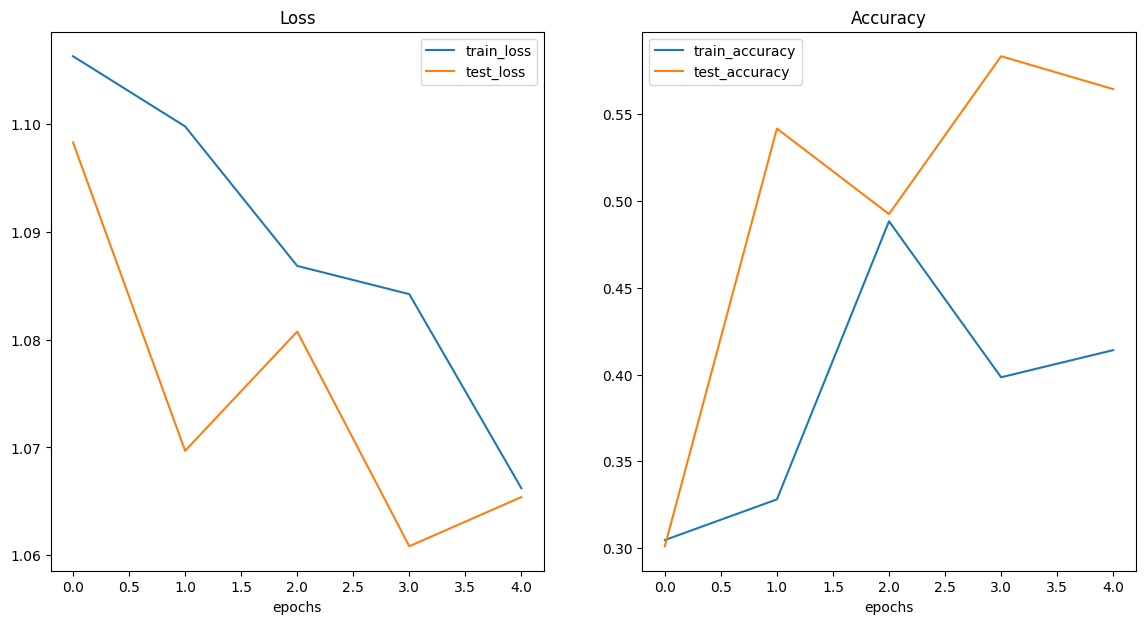

In [43]:
plot_loss_curves(model_0_results)


##Model 1 (TinyVGG with data augmentation)

###creating transforms with data augmentation


In [44]:
from torchvision import transforms
train_transform_augmented=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

###creating train and test  dataset and dataloader with data augmentation

In [45]:
from torchvision import datasets

train_data_augmented=datasets.ImageFolder(root=train_dir,
                                           transform=train_transform_augmented)
test_data_simple=datasets.ImageFolder(root=test_dir,
                                      transform=test_transform_simple)

In [46]:
from torch.utils.data import dataloader
import os

BATCH_SIZE=32
torch.manual_seed(42)
train_dataloader_augmented=DataLoader(dataset=train_data_augmented,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle=True)

test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle=False)

###constructing and traning Model 1

In [47]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1=TinyVGG(input_shape=3,hidden_units=10,output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [110]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),
                           lr=0.001)

start_time=timer()
model_1_results=train(model=model_1,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=5)
end_time=timer()
print_time(start_time,end_time)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 0.9288 | train_acc: 54.2969%  | test_loss: 0.9798 | test_acc: 38.2576%
Epoch: 1 | train_loss: 0.9719 | train_acc: 48.4375%  | test_loss: 1.0632 | test_acc: 33.2386%
Epoch: 2 | train_loss: 0.8165 | train_acc: 60.5469%  | test_loss: 1.0588 | test_acc: 36.3636%
Epoch: 3 | train_loss: 0.8449 | train_acc: 61.7188%  | test_loss: 1.0417 | test_acc: 34.2803%
Epoch: 4 | train_loss: 0.8147 | train_acc: 63.6719%  | test_loss: 1.0608 | test_acc: 36.2689%
Time taken: 11.226 seconds


In [55]:
model_1_results


{'train_loss': [1.0395429953932762,
  1.030704490840435,
  0.9312388524413109,
  1.0029231160879135,
  0.9556870684027672],
 'train_acc': [0.41796875, 0.41015625, 0.53125, 0.453125, 0.56640625],
 'test_loss': [1.0143373409907024,
  1.079289694627126,
  1.0926613608996074,
  1.06946196158727,
  1.0728519558906555],
 'test_acc': [0.3210227272727273,
  0.3125,
  0.3229166666666667,
  0.32196969696969696,
  0.2916666666666667]}

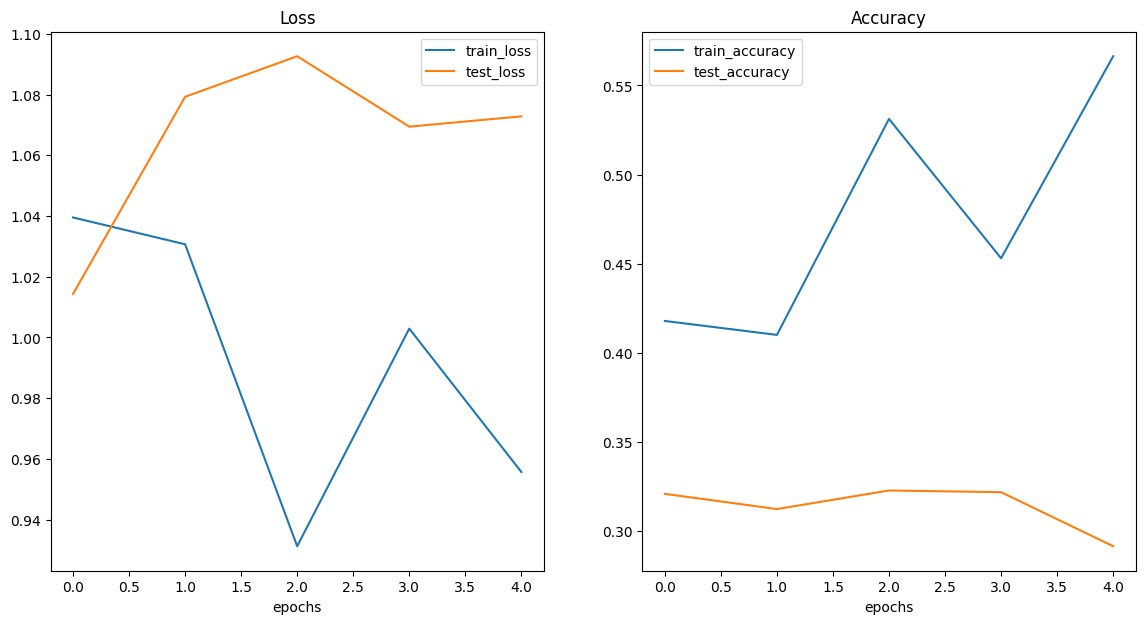

In [56]:
plot_loss_curves(model_1_results)

In [ ]:
#the model is both underfitted and overfitted

##Comparing both model resuls

In [57]:
import pandas as pd

model_0_df=pd.DataFrame(model_0_results)
model_1_df=pd.DataFrame(model_1_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394


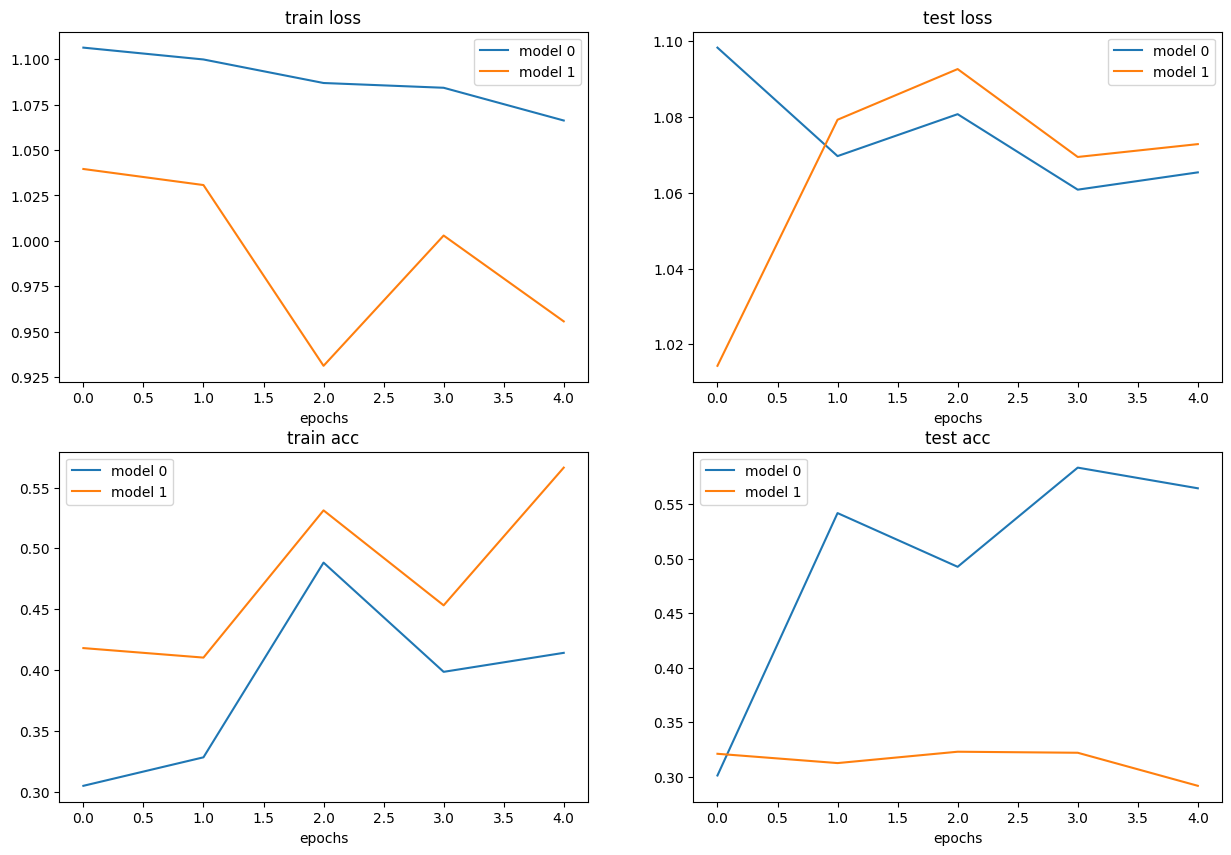

In [65]:
import matplotlib.pyplot as plt
epochs=range(len(model_0_df))


plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="model 0")
plt.plot(epochs,model_1_df["train_loss"],label="model 1")
plt.xlabel("epochs")
plt.title("train loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="model 0")
plt.plot(epochs,model_1_df["test_loss"],label="model 1")
plt.title("test loss")
plt.xlabel("epochs")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"],label="model 0")
plt.plot(epochs,model_1_df["train_acc"],label="model 1")
plt.title("train acc")
plt.xlabel("epochs")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="model 0")
plt.plot(epochs,model_1_df["test_acc"],label="model 1")
plt.title("test acc")
plt.xlabel("epochs")
plt.legend()

##Making prediction on custom image

In [66]:
import requests

custom_image_path=data_path/"custom_pizza_image.jpeg"

#dowloading image
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    request=requests.get("https://shorturl.at/DQHf6")
    print(f"dowloading image..")
    f.write(request.content)
else:
  print(f"the image already exists")



dowloading image..


###loading custom image

the custom image should be of size 64x64x3
and datatype torch.float62

In [85]:
import torchvision
custom_image_uint8=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image_uint8

tensor([[[0.6902, 0.6863, 0.6706,  ..., 0.9137, 0.9216, 0.9255],
         [0.5882, 0.5804, 0.5608,  ..., 0.9137, 0.9176, 0.9176],
         [0.5098, 0.5059, 0.4863,  ..., 0.9255, 0.9137, 0.9176],
         ...,
         [0.7922, 0.7961, 0.7961,  ..., 0.4392, 0.4353, 0.4314],
         [0.8118, 0.8353, 0.8549,  ..., 0.4353, 0.4353, 0.4353],
         [0.8667, 0.8510, 0.8235,  ..., 0.4039, 0.4078, 0.4078]],

        [[0.8196, 0.8196, 0.8000,  ..., 0.2000, 0.1961, 0.2000],
         [0.7098, 0.7059, 0.6941,  ..., 0.2000, 0.2000, 0.2000],
         [0.6235, 0.6157, 0.6039,  ..., 0.1961, 0.2000, 0.2039],
         ...,
         [0.8000, 0.8039, 0.8039,  ..., 0.2863, 0.2824, 0.2784],
         [0.8196, 0.8431, 0.8627,  ..., 0.2980, 0.2980, 0.2980],
         [0.8745, 0.8588, 0.8314,  ..., 0.2706, 0.2745, 0.2745]],

        [[0.1333, 0.1373, 0.1451,  ..., 0.0039, 0.0157, 0.0196],
         [0.0706, 0.0745, 0.0784,  ..., 0.0157, 0.0353, 0.0353],
         [0.0745, 0.0784, 0.0784,  ..., 0.0431, 0.0549, 0.

(-0.5, 274.5, 182.5, -0.5)

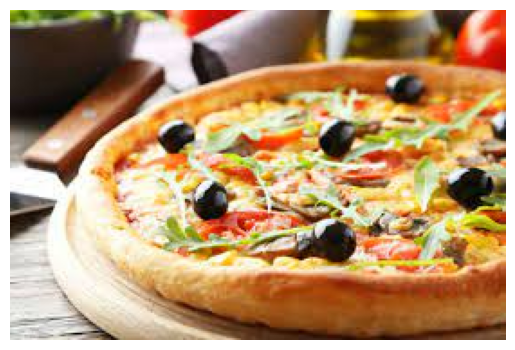

In [86]:
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis("off")

In [88]:
custom_image_transform=transforms.Compose([
    transforms.Resize((64,64))
])

custom_image_transformed=custom_image_transform(custom_image_uint8)
print(f"custom image shape: {custom_image_uint8.shape}")
print(f"custom image transformed shape: {custom_image_transformed.shape}")

custom image shape: torch.Size([3, 183, 275])
custom image transformed shape: torch.Size([3, 64, 64])


In [95]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_0(custom_image_transformed.unsqueeze(dim=0).to(device))



In [96]:
custom_image_pred


tensor([[-0.0574, -0.1650,  0.0047]])

In [100]:
#converting logit to prediction probabilities
custom_image_pred_probs=torch.softmax(custom_image_pred,dim=1)
custom_image_pred_probs

#converting probabilities into labels
custom_image_pred_label=torch.argmax(custom_image_pred_probs,dim=1).cpu()
custom_image_pred_label



tensor([2])

In [101]:
class_names[custom_image_pred_label]

'sushi'

In [104]:
def pred_and_plot_image(model: torch.nn.Module,
                      image_path:str,
                      class_names: list[str]=None,
                      transform=None,
                      device=device):

  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)/255

  if transform is not None:
    target_image=transform(target_image)
  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image_pred=model(target_image.unsqueeze(dim=0).to(device))

  target_image_pred_label=torch.argmax(torch.softmax(target_image_pred,dim=1),dim=1).cpu()
  plt.imshow(target_image.permute(1,2,0))
  plt.title(f"pred: {class_names[target_image_pred_label]}")
  plt.axis("off")

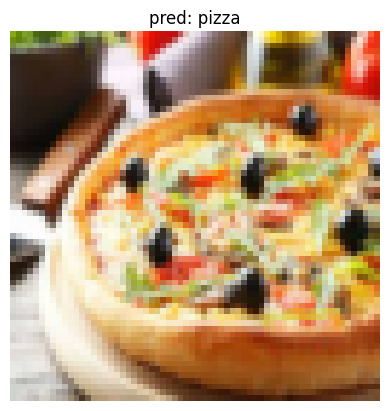

In [112]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform)